# Task1 赛题理解

## 1. 赛事介绍
### 数据集
* 赛题来源自Google街景图像中的门牌号数据集（The Street View House Numbers Dataset, SVHN），并根据一定方式采样得到比赛数据集。
* 该数据来自真实场景的门牌号。训练集数据包括3W张照片，验证集数据包括1W张照片，每张照片包括颜色图像和对应的编码类别和具体位置；为了保证比赛的公平性，测试集A包括4W张照片，测试集B包括4W张照片。
![数据集样本展示](IMG/赛事简介/数据集样本展示.png)
* 需要注意的是本赛题需要选手识别图片中所有的字符，为了降低比赛难度，提供了训练集、验证集和测试集中字符的位置框。
### 注意
* 只能使用比赛给定的数据集完成训练，不能使用SVHN原始数据集进行训练。
* 允许使用CIFAR-10和ImageNet数据集的预训练模型，不允许使用其他任何预训练模型和任何外部数据；  

### 数据标签
* 所有的数据（训练集、验证集和测试集）的标注使用JSON格式，并使用文件名进行索引。
* 对于训练数据每张图片将给出对于的编码标签，和具体的字符框的位置（训练集、测试集和验证集都给出字符位置），可用于模型训练：

 Field  | Description|
--------- | --------|
top	| 左上角坐标X |
height	| 字符高度 |
left   | 左上角最表Y |
width  | 字符宽度 |
label  | 字符编码 |
* 字符的坐标具体如下所示：     
![坐标](IMG/Task01/字符坐标.png)

*  在比赛数据（训练集、测试集和验证集）中，同一张图片中可能包括一个或者多个字符，因此在比赛数据的JSON标注中，会有多个字符的边框信息： 
     
 |原始图片|图片JSON标注|
 |----|-----|
 ![19](IMG/Task01/原始图片.png)    | ![标注](IMG/Task01/原始图片标注.png)  |

* 注：数据集来源自SVHN，网页链接 http://ufldl.stanford.edu/housenumbers/ ，并进行匿名处理和噪音处理，请各位选手使用比赛给定的数据集完成训练。
### 评分方式
* 评价标准为准确率。
* 提交结果与实际图片的编码进行对比，以编码整体识别准确率为评价指标。任何一个字符错误都为错误，最终评测指标结果越大越好。
* Score=编码识别正确的数量/测试集图片数量

### 结果格式     
预测结果的格式与sample_submit.csv中的格式一致，以及提交文件后缀名为csv。       
形式如下：      
file_name, file_code       
0010000.jpg,451      
0010001.jpg,232     
0010002.jpg,45     
0010003.jpg,67     
0010004.jpg,191     
0010005.jpg,892 

## 2. 读取数据

JSON中标签的读取方式：

安装cv2: pip install opencv-python

In [5]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

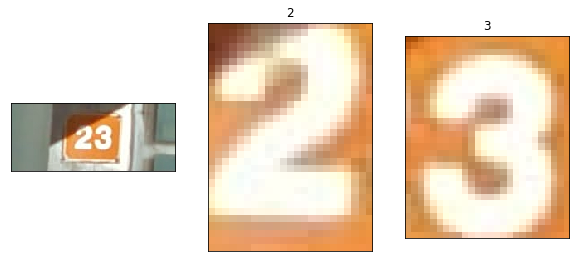

In [7]:
train_json = json.load(open('../../data/Datawhale-Tianchi-CV_SVHN/mchar_train.json'))

# 数据标注处理
def parse_json(d):
   arr = np.array([
       d['top'], d['height'], d['left'],  d['width'], d['label']
   ])
   arr = arr.astype(int)
   return arr

img = cv2.imread('../../data/Datawhale-Tianchi-CV_SVHN/mchar_train/000001.png')
arr = parse_json(train_json['000001.png'])

plt.figure(figsize=(10, 10))
plt.subplot(1, arr.shape[1]+1, 1)
plt.imshow(img)
plt.xticks([]); plt.yticks([])

for idx in range(arr.shape[1]):
   plt.subplot(1, arr.shape[1]+1, idx+2)
   plt.imshow(img[arr[0, idx]:arr[0, idx]+arr[1, idx],arr[2, idx]:arr[2, idx]+arr[3, idx]])
   plt.title(arr[4, idx])
   plt.xticks([]); plt.yticks([])

## 3. 解题思路

赛题本质是分类问题，需要对图片的字符进行识别。但赛题给定的数据图片中不同图片中包含的字符数量不等，如下图所示。有的图片的字符个数为2，有的图片字符个数为3，有的图片字符个数为4。

|字符属性|图片|
 |----|-----|
 |字符：42   字符个数：2    | ![标注](IMG/Task01/42.png)  |
 |字符：241   字符个数：3    | ![标注](IMG/Task01/2411.png)  |
 |字符：7358   字符个数：4    | ![标注](IMG/Task01/7358.png)  |

因此本次赛题的难点是需要对不定长的字符进行识别，与传统的图像分类任务有所不同。

### 3.1 简单入门思路：定长字符识别    
     
可以将赛题抽象为一个定长字符识别问题，在赛题数据集中大部分图像中字符个数为2-4个，最多的字符个数为6个。                 
因此可以对于所有的图像都抽象为6个字符的识别问题，字符23填充为23XXXX，字符231填充为231XXX。      
![标注](IMG/Task01/23xxxxxx.png)   

经过填充之后，原始的赛题可以简化了6个字符的分类问题。在每个字符的分类中会进行11个类别的分类，假如分类为填充字符，则表明该字符为空。

### 3.2 专业字符识别思路：不定长字符识别 
        
![标注](IMG/Task01/不定长字符识别.png)      
            
在字符识别研究中，有特定的方法来解决此种不定长的字符识别问题，比较典型的有CRNN字符识别模型。     
在本次赛题中给定的图像数据都比较规整，可以视为一个单词或者一个句子。

### 3.3 专业分类思路：检测再识别     
      
在赛题数据中已经给出了训练集、验证集中所有图片中字符的位置，因此可以首先将字符的位置进行识别，利用物体检测的思路完成。        
      
![IMG](IMG/Task01/检测.png)           
            
此种思路需要参赛选手构建字符检测模型，对测试集中的字符进行识别。选手可以参考物体检测模型SSD或者YOLO来完成。

三种解决思路的难度从低到高，建议入门学习的同学可以先学习定长字符识别的思路。在文档之后的内容中也会以定长字符识别为例。